# Defining the Question


### a) Specifying the Question

> Create a cross-lingual machine learning model focused on Political Hate Speech in Kenya which classifies whether an online post is deemed hate speech and the severity(sub-class) of it if so or not not hate speech (normal speech).

### b) Defining the Metric for Success



> An overall classification accuracy of 80% and Hate Class Recall of 70%.

### c) Understanding the context

> In an increasingly digital era where online social interactions are considered part of the social context, it is proving inevitable that machine learning should be used to protect people from harmful content. This has been evidenced by the multitude of instances where hate speech propagated online (mostly based on misinformation) has led to physical injury and loss of lives across the world. Government institutions should now consider online interactions as spaces where potential crimes may occur just like in the physical world.


> The goal of identifying hate speech efficiently and accurately irrespective of language is becoming a necessity. Countries like Kenya amongst other African nations have experienced the consequences of not dealing with hate speech as evidenced in previous years. Agencies such as the National Cohesion & Integration Commission were formed to help with this. Section 13 of National Cohesion and Integration Act(2008) outlines what is considered hate speech. In combination with the act an automated way of flagging hate speech would prove helpful for the institution given the country’s context which may not be similar to other countries meaning posts may not be picked/flagged by social media companies such as Twitter and Facebook as a result.


> Political hate speech is the greatest area of concern in regards to Kenya and thus we’ll be our area of focus. Looking at whether a post is Hate Speech or Normal Speech and it's severity (sub-class). 


### d) Recording the Experimental Design


> The following design was used:


* Data importation
* Data Reading & Pre-processing
* EDA
* Unsupervised Topic Modeling
* Semi-Supervised Hate Speech Detection
  - Optimization/Tuning


### e) Data Relevance

> This was evaluated against the metric of success (after implementation of solution)

# Data Preparation

### Importing our Libraries

In [19]:
# installing the necessary libraries not in google colab
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.12.0-py2.py3-none-any.whl size=243829 sha256=ca629c770c91b0be9844234a62289a47823a4e6758f94406ab3f6b50acdd3741
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsq79hjv/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


In [20]:
! pip install nltk

In [21]:
! pip install spacy

In [22]:
! python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [23]:
! pip install sparknlp

In [24]:
# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

Processing /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471/pyspark-2.4.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e3/53/c737818eb9a7dc32a7cd4f1396e787bd94200c3997c72c1dbe028587bd76/py4j-0.10.7-py2.py3-none-any.whl


In [25]:
!pip install googletrans

In [26]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

openjdk version "1.8.0_282"
OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)


In [27]:
# Let us first import all the libraries we will need for our analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import re
from matplotlib import pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport
from scipy import stats
from scipy.stats import norm
import math
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
import nltk
import spacy
import sparknlp

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/iolib/foreign.py:633: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _type_converters = {253 : np.long, 252 : int}
/usr/local/l

In [28]:
# let us set the warnings that may appear in our analysis off

import warnings
warnings.filterwarnings('ignore') 

# subsequently let us set the pandas warning for chained assignments off
pd.options.mode.chained_assignment = None  # default='warn'

### Loading and Previewing our Dataset

In [ ]:
# Loading the Dataset from the source i.e. csv
a = pd.read_excel('/content/Friday_copy_hatespeech_sample_data2.xlsx')
b = pd.read_excel('/content/Thursday_copy_hatespeech_sample_data1.xlsx')
c = pd.read_excel('/content/Saturday_copy_hatespeech_sample_data3.xlsx')
frames = [a, b, c]

df = pd.concat(frames)
df.head()

user  ... hashtags
0  timothymutuake  ...       []
1     iamthe_mwas  ...       []
2         kwibita  ...       []
3   ngalih_junior  ...       []
4      allak_weda  ...       []

[5 rows x 12 columns]

## Checking the Data

In [ ]:
# Determining the no. of records in our  dataset
#
print('This hatespeeech dataset has ' + str(df.shape[0]) + ' rows, and ' + str(df.shape[1]) + ' columns')

This hatespeeech dataset has 2583 rows, and 12 columns


In [ ]:
# Checking whether each column has an appropriate datatype
#
df.dtypes

user                                           object
tweet                                          object
hate_speech(1=hspeech, 0=nohspeech)           float64
location                                       object
description                                    object
friends_count                                 float64
followers_count                               float64
statuses_count                                float64
tweet_date                             datetime64[ns]
retweet_count                                 float64
likes                                         float64
hashtags                                       object
dtype: object

In [ ]:
# checking the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2583 entries, 0 to 959
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   user                                 2582 non-null   object        
 1   tweet                                2582 non-null   object        
 2   hate_speech(1=hspeech, 0=nohspeech)  1363 non-null   float64       
 3   location                             2558 non-null   object        
 4   description                          2342 non-null   object        
 5   friends_count                        2582 non-null   float64       
 6   followers_count                      2582 non-null   float64       
 7   statuses_count                       2582 non-null   float64       
 8   tweet_date                           2582 non-null   datetime64[ns]
 9   retweet_count                        2582 non-null   float64       
 10  likes        

In [ ]:
# let us see the columns in our dataframe
df.columns

Index(['user', 'tweet', 'hate_speech(1=hspeech, 0=nohspeech)', 'location',
       'description', 'friends_count', 'followers_count', 'statuses_count',
       'tweet_date', 'retweet_count', 'likes', 'hashtags'],
      dtype='object')

In [ ]:
# Checking the entire profile of the dataframe
profile = ProfileReport(df, title="Tweets Profile Report", html={'style':{'full_width':True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# let us save our profile report
profile.to_file(output_file="Tweets_Profile_Report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Cleaning

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
df_copy = df.copy(deep = True)

In [ ]:
# For consistency, the column names should be uniform
# Let us change all column names to lower case
#
df_copy.columns = df_copy.columns.str.lower()
# Previewing the columns to confirm whether the changes have taken effect
#
df_copy.columns

Index(['user', 'tweet', 'hate_speech(1=hspeech, 0=nohspeech)', 'location',
       'description', 'friends_count', 'followers_count', 'statuses_count',
       'tweet_date', 'retweet_count', 'likes', 'hashtags'],
      dtype='object')

In [ ]:
# let us replace the hatespeech column name
df_copy.rename(columns = {'hate_speech(1=hspeech, 0=nohspeech)': 'hate_speech'}, inplace=True)
df_copy.columns 

Index(['user', 'tweet', 'hate_speech', 'location', 'description',
       'friends_count', 'followers_count', 'statuses_count', 'tweet_date',
       'retweet_count', 'likes', 'hashtags'],
      dtype='object')

In [ ]:
# let us check for duplicates
df_copy.duplicated().sum()

56

In [ ]:
# let us drop the duplicates
df_copy.drop_duplicates(inplace=True)
df_copy.duplicated().sum()

0

In [ ]:
# Let Us Drop the columns that do contribute to 
# whether a passenger survives or not 

df_copy.drop(['user','description', 'hashtags'], axis=1, inplace=True)

# let us confirm that we have dropped the unnecessary columns
df_copy.head()

tweet  ...  likes
0  @Keiyot_ @JohnRoyMwaniki @KereYvonne @NelsonHa...  ...    1.0
1                  @MissKwegah1 Luhyas group of food  ...    1.0
2  @smileycherry2 Don't beat around the bush, wal...  ...    4.0
3  @Cockey_ninja @AizoOzill Act of generosity whi...  ...    2.0
4  @ArapTilingi Luos and Luhyas have been doing t...  ...    0.0

[5 rows x 9 columns]

In [ ]:
# let us check for missing values in our dataframe
null_list = list(df_copy.columns.values)

for n in null_list:
    print (n,": ",sum(pd.isnull(df_copy[n])))
#We have 177 NaN in Age and 2 in Embarked.

tweet :  1
hate_speech :  1218
location :  24
friends_count :  1
followers_count :  1
statuses_count :  1
tweet_date :  1
retweet_count :  1
likes :  1


In [ ]:
# let us see how much information we lose by dropping the null values
df_clean = df_copy.dropna()
print('Shape of dataframe with no missing values: ', df_clean.shape)
print('Shape of dataframe with missing values: ', df_copy.shape)
# by dropping our null values we have dropped just 80 rows of our dataframe
# this is not a significant part of our dataset which is ideal
# therefore we will work with the clean dataframe

Shape of dataframe with no missing values:  (1295, 9)
Shape of dataframe with missing values:  (2526, 9)


In [ ]:
df_clean.isnull().sum()

tweet              0
hate_speech        0
location           0
friends_count      0
followers_count    0
statuses_count     0
tweet_date         0
retweet_count      0
likes              0
dtype: int64

In [ ]:
#export cleanfile to csv
df_clean.to_csv('clean_hatespeech2.csv')

# Exploratory Data Analysis

In [ ]:
# let us see some info on our dataset
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 959
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tweet            1295 non-null   object        
 1   hate_speech      1295 non-null   float64       
 2   location         1295 non-null   object        
 3   friends_count    1295 non-null   float64       
 4   followers_count  1295 non-null   float64       
 5   statuses_count   1295 non-null   float64       
 6   tweet_date       1295 non-null   datetime64[ns]
 7   retweet_count    1295 non-null   float64       
 8   likes            1295 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 101.2+ KB


In [ ]:
# let us see some summary statistics of the dataset
df_clean.describe()

hate_speech  friends_count  ...  retweet_count        likes
count  1295.000000    1295.000000  ...    1295.000000  1295.000000
mean      0.414672    1843.691120  ...       1.758301     9.471042
std       0.492856    4621.572106  ...      17.677852    82.088375
min       0.000000       0.000000  ...       0.000000     0.000000
25%       0.000000     295.000000  ...       0.000000     0.000000
50%       0.000000     783.000000  ...       0.000000     1.000000
75%       1.000000    2192.500000  ...       0.000000     2.000000
max       1.000000  135576.000000  ...     445.000000  2312.000000

[8 rows x 6 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a4a1ced50>,
      dtype=object)

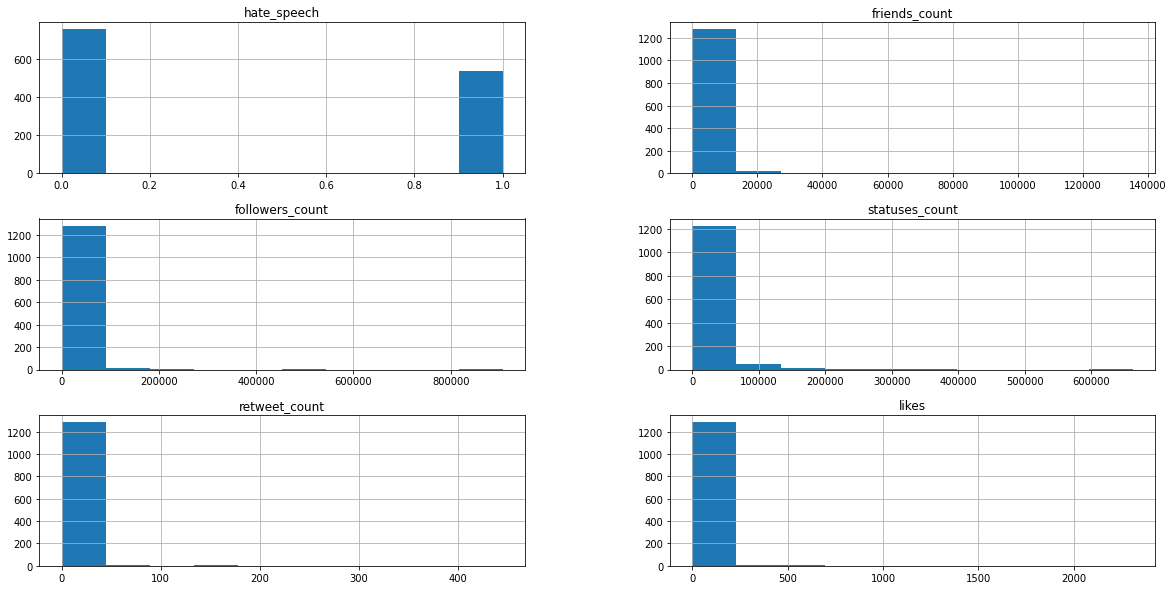

In [ ]:
# let us plot histograms to visualize patterns in the data
df_clean.hist(figsize = (20,10))

Text(0.5, 1.0, 'Checking for outliers using boxplots')

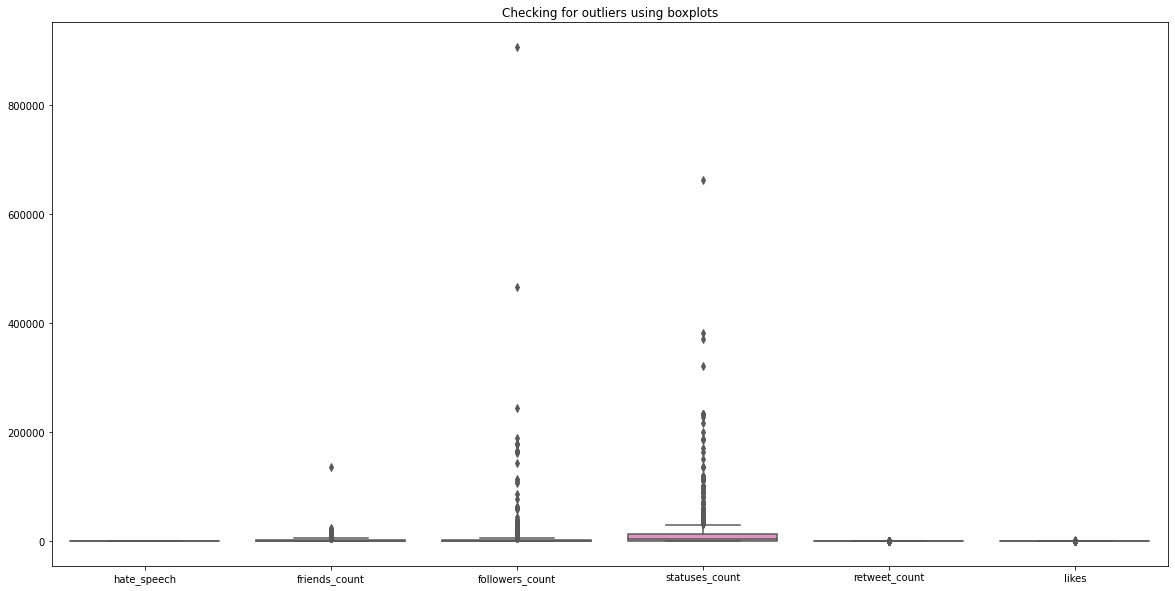

In [ ]:
# Boxplots to Visualize outliers of our numerical columns 
plt.figure(figsize = (20,10))
ax = sns.boxplot(data=df_clean, orient="v", palette="Set2")
plt.title('Checking for outliers using boxplots')
# The boxplots below indicate the outliers in each of the numerical columns

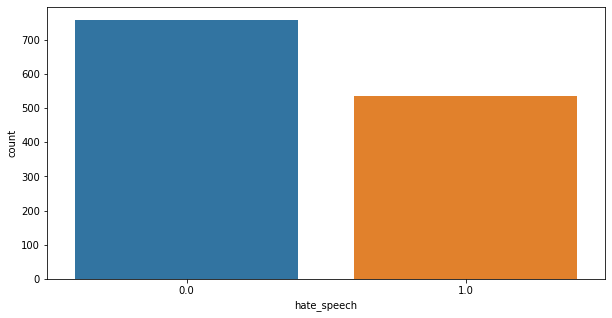

In [ ]:
# let us see how the labels are distributed in our dataset
plt.figure(figsize=(10,5))
sns.countplot(x="hate_speech", data = df_clean)

# normal speech is greater than hatespeech 

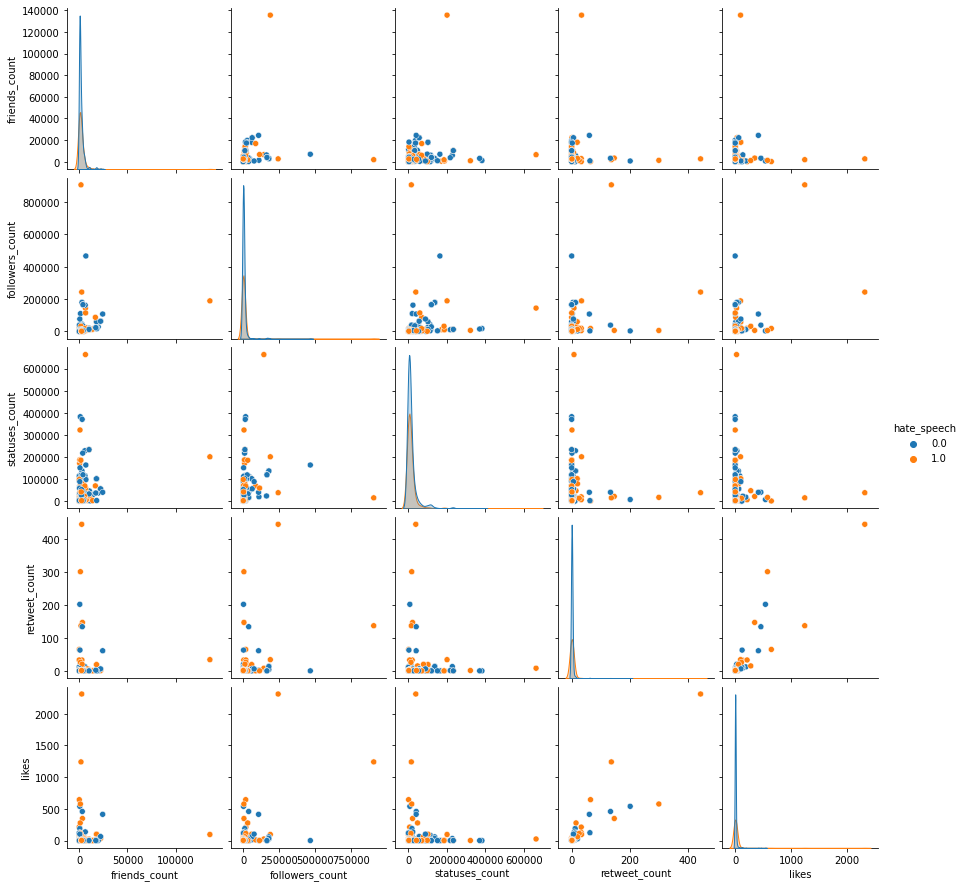

In [ ]:
# Ploting the bivariate summaries and recording our observations
sns.pairplot(df_clean, hue="hate_speech")
plt.show()

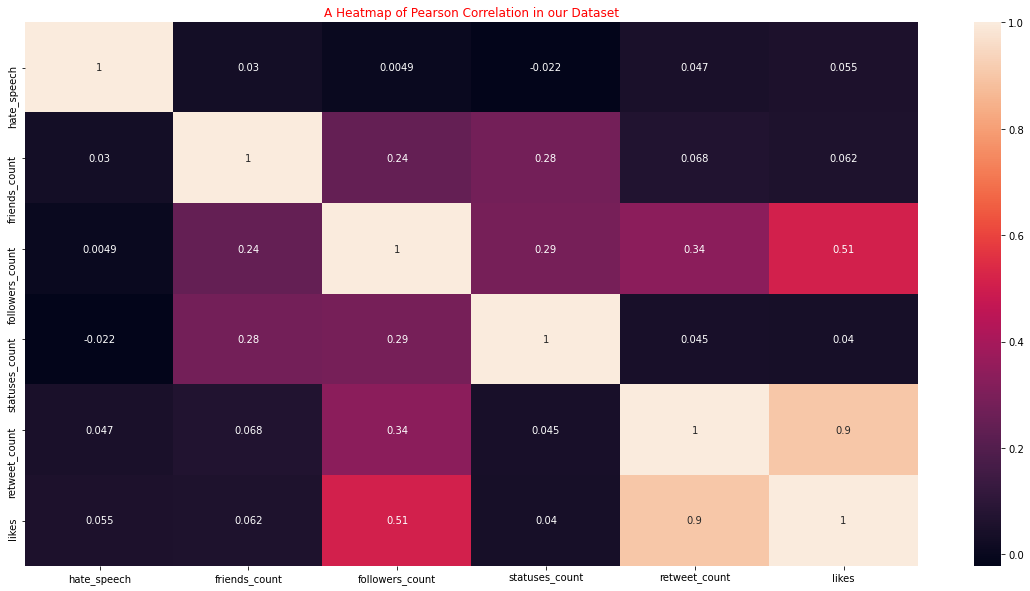

In [ ]:
# Calculating the pearson coefficient correlation
a = df_clean.corr() 
plt.figure(figsize = (20,10))
sns.heatmap(a, xticklabels=a.columns, yticklabels=a.columns, annot=True)
plt.title('A Heatmap of Pearson Correlation in our Dataset', color='red')
plt.show()
# From this we can see there is a correlation between t3 and tt4.

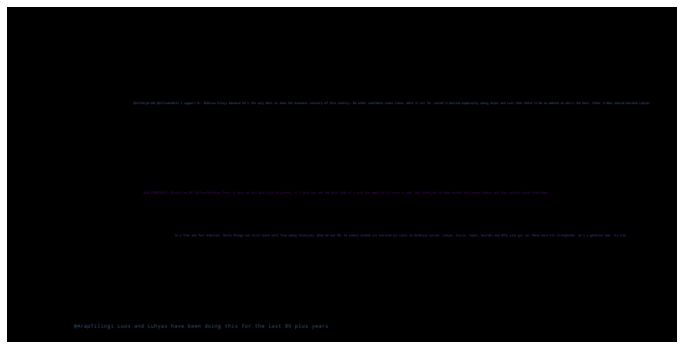

In [ ]:
# Most common words
from wordcloud import WordCloud
from nltk import FreqDist
#Frequency of words
fdist = FreqDist(df_clean['tweet'])
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Data Pre-Processing

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
data = df_clean.copy(deep = True)

In [ ]:
# let us change the data type of our tweet column
data.info()
data.tweet= data.tweet.astype(str)
data.hate_speech = data.hate_speech.astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 959
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tweet            1295 non-null   object        
 1   hate_speech      1295 non-null   float64       
 2   location         1295 non-null   object        
 3   friends_count    1295 non-null   float64       
 4   followers_count  1295 non-null   float64       
 5   statuses_count   1295 non-null   float64       
 6   tweet_date       1295 non-null   datetime64[ns]
 7   retweet_count    1295 non-null   float64       
 8   likes            1295 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 141.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 959
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tweet            1295 n

In [ ]:
# let us create a dataset with only our columns of interest 
tweets = data[['tweet', 'hate_speech']]
tweets.head()

tweet hate_speech
0  @Keiyot_ @JohnRoyMwaniki @KereYvonne @NelsonHa...         1.0
1                  @MissKwegah1 Luhyas group of food         0.0
2  @smileycherry2 Don't beat around the bush, wal...         0.0
3  @Cockey_ninja @AizoOzill Act of generosity whi...         0.0
4  @ArapTilingi Luos and Luhyas have been doing t...         0.0

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
copy1 = tweets.copy(deep=True)

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
copy2 = tweets.copy(deep=True)

In [ ]:
# let us make a copy of our dataset to clean and do modelling on
tweets_c = tweets.copy(deep=True)

### Google translate

In [ ]:
#cleaning so as to translate
# Using regex 

# Converting all characters in the tweet to lower case
#tweets_c['tweet'] = tweets_c.tweet.map(lambda x: x.lower())

#url removes
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b','')
tweets_c['tweet']= tweets_c['tweet'].str.replace(r'www\.\S+\.com','')

#removes retweets & cc
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'rt|cc', '')

#hashtags removes
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'#\S+', '')

#user mention removes
tweets_c['tweet'] =tweets_c['tweet'].str.replace(r'@\S+', '')

#emoji 
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'[^\x00-\x7F]+', '')

#html tags
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r'<.*?>', '')

#removes extra spaces
tweets_c['tweet'] = tweets_c['tweet'].str.replace(r' +', ' ')

#punctuation
tweets_c['tweet'] = tweets_c['tweet'].str.replace('[^\w\s]', '').astype(str) 

#convert preprocessed list words to string 
tweets_c['tweet'] = tweets_c['tweet'].apply(''.join)

In [ ]:
!pip install google_trans_new

In [ ]:
from spacy.lang.en import English

nlp = English()

#convert tweet column to list
twl_1 = list(tweets_c.tweet)

from google_trans_new import google_translator  
translator = google_translator()  

#empyt list to hold translated tweets
trans_l = []

#iterate over each tweet to translate
for x in range(len(twl_1)):
  translate_text = translator.translate(twl_1[x],lang_src='sw', lang_tgt='en')  
  trans_l.append(translate_text)

#create a dataframe to hold the translated tweets
trans_ldf = pd.DataFrame(trans_l, columns=['transl_tweet'])
trans_ldf

#append it as a column back to the original dataframe and drop non-translated col
#reset the original df index
tweets_c.reset_index(inplace=True)
tweets_c['transl_tweet']= trans_ldf
tweets_ct = tweets_c.drop('tweet', axis=1)

In [ ]:
#lowercase the translated tweets
trans_ldf.transl_tweet = trans_ldf.transl_tweet.str.lower()

In [ ]:
# let us export the translated tweets to a csv file
trans_ldf.to_csv('translated_hatespeech2.csv')

In [ ]:
# let us export the translated tweets to a csv file
tweets_ct.to_csv('tweetsct_hatespeech2.csv')

In [ ]:
#tokenizer, pos tagging and entity recognition
nlp = spacy.load('en')

trans_ldf.transl_tweet  = trans_ldf.transl_tweet.apply(lambda x: nlp(x))

In [ ]:
#stemming/lemmatization
trans_ldf.transl_tweet = trans_ldf.transl_tweet.apply(lambda x: [item.lemma_ for item in x ])

In [ ]:
#remove stop words
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

#remove stopwords
trans_ldf.transl_tweet = trans_ldf.transl_tweet.apply(lambda x: [item for item in x if item not in all_stopwords])

#convert preprocessed list words to string 
trans_ldf.transl_tweet = trans_ldf.transl_tweet.apply(' '.join)

In [ ]:
#append to df and drop col
tweets_ct['tweet'] = trans_ldf
final = tweets_ct.drop(['index','transl_tweet'], axis=1)
final

hate_speech                                              tweet
0            1.0  point correction kambas practise witchcraft pa...
1            0.0                                  luhyas group food
2            0.0                        beat bush waluhya character
3            0.0                       act generosity common kambas
4            0.0                           luos luhyas 80 plus year
...          ...                                                ...
1290         0.0        jayden play like -PRON- tomorrow early bird
1291         0.0                                        tml tweet .
1292         0.0                      jayden train firearm handling
1293         1.0  jayden rich kid character -PRON- thing like -P...
1294         1.0  kenya -PRON- deal gun violence soon forgeette ...

[1295 rows x 2 columns]

In [ ]:
final.to_csv('final_hatespeech2.csv')

# Importing translated cleaned dataset

In [1]:
import pandas as pd
final = pd.read_csv('/content/final_hatespeech2.csv')
#final.drop('Unnamed: 0', inplace= True)
final.head()

Unnamed: 0  hate_speech                                              tweet
0           0          1.0  point correction kambas practise witchcraft pa...
1           1          0.0                                  luhyas group food
2           2          0.0                        beat bush waluhya character
3           3          0.0                       act generosity common kambas
4           4          0.0                           luos luhyas 80 plus year

In [12]:
final.isnull().sum()
final.dropna(inplace=True)
final.isnull().sum()

Unnamed: 0     0
hate_speech    0
tweet          0
dtype: int64

In [13]:
final.shape

(1293, 3)

In [14]:
# let us make a copy of our dataset to clean and do modelling on
final_copy = final.copy(deep=True)

In [15]:
# let us make a copy of our dataset to clean and do modelling on
df1 = final_copy.copy(deep=True)

In [16]:
# let us make a copy of our dataset to clean and do modelling on
df = final_copy.copy(deep=True)

In [ ]:
# Finally, we will transform the data into occurrences, 
# which will be the features that we will feed into our model
# 
from sklearn.feature_extraction.text import CountVectorizer 
# build a vocabulary that only consider the top max_features ordered by the term frequency across the column
vectorizer = CountVectorizer(max_features=100)
# the function fit_transform() is used for dataset transformation in scikit learn
x = vectorizer.fit_transform(df.tweet).toarray()
y = df.hate_speech.values

# This

In [ ]:
# compare algorithms
from matplotlib import pyplot
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# split the data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=0)

# #scale the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train) 
# X_test = sc.transform(X_test)

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))
# evaluate each model in turn
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.646754 (0.065425)
LDA: 0.656893 (0.063865)
KNN: 0.583405 (0.060440)
CART: 0.578861 (0.053755)
RF: 0.613865 (0.066925)
GBC: 0.658385 (0.073898)
NB: 0.588274 (0.067041)
SVM: 0.645963 (0.058646)
XGB: 0.668456 (0.080837)


# Naive Bayes Model

In [ ]:
# Training the Model
# We will start by splitting our data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Fitting our model 
# Then, all that we have to do is initialize the Naive Bayes Classifier and fit the data. 
# For text classification problems, the Multinomial Naive Bayes Classifier is well-suited
# 
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(X_train, y_train)

# Evaluating the Model
# Once we have put together our classifier, we can evaluate its performance in the testing set
# 
predicted = model.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, predicted)}')
print(f'The auc score is: {roc_auc_score(y_test, predicted)}')
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))

The accuracy score is: 0.6023166023166023
The auc score is: 0.5810647307924984
[[110  35]
 [ 68  46]]
              precision    recall  f1-score   support

         0.0       0.62      0.76      0.68       145
         1.0       0.57      0.40      0.47       114

    accuracy                           0.60       259
   macro avg       0.59      0.58      0.58       259
weighted avg       0.60      0.60      0.59       259



In [ ]:
# Training our model and printing out metrics
# 
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()  
model = clf.fit(X_train, y_train) 
predicted = model.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, predicted)}')
print(f'The auc score is: {roc_auc_score(y_test, predicted)}')
print(confusion_matrix(y_test, predicted))
print(classification_report(y_test, predicted))

The accuracy score is: 0.637065637065637
The auc score is: 0.6149122807017544
[[116  29]
 [ 65  49]]
              precision    recall  f1-score   support

         0.0       0.64      0.80      0.71       145
         1.0       0.63      0.43      0.51       114

    accuracy                           0.64       259
   macro avg       0.63      0.61      0.61       259
weighted avg       0.64      0.64      0.62       259



# Random Forest Model

In [ ]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


# Import the model
from sklearn.ensemble import RandomForestClassifier

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
forest = RandomForestClassifier(n_estimators = 100, random_state=42, min_samples_split = 20, max_depth=5)
forest = forest.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = forest.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.6216216216216216
The auc score is: 0.5776769509981852
[[137   8]
 [ 90  24]]
              precision    recall  f1-score   support

         0.0       0.60      0.94      0.74       145
         1.0       0.75      0.21      0.33       114

    accuracy                           0.62       259
   macro avg       0.68      0.58      0.53       259
weighted avg       0.67      0.62      0.56       259



In [ ]:
# We will start by splitting our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# decision tree evaluated on imbalanced dataset with SMOTE oversampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# # define dataset
# X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
#                            n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

# define pipeline
steps = [('model', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))
print(mean(scores))

0.6132925560173438


# SVM 

In [ ]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = svclassifier.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.6023166023166023
The auc score is: 0.5791893526920749
[[112  33]
 [ 70  44]]
              precision    recall  f1-score   support

         0.0       0.62      0.77      0.69       145
         1.0       0.57      0.39      0.46       114

    accuracy                           0.60       259
   macro avg       0.59      0.58      0.57       259
weighted avg       0.60      0.60      0.59       259



In [ ]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = svclassifier.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.5868725868725869
The auc score is: 0.5560193587416817
[[118  27]
 [ 80  34]]
              precision    recall  f1-score   support

         0.0       0.60      0.81      0.69       145
         1.0       0.56      0.30      0.39       114

    accuracy                           0.59       259
   macro avg       0.58      0.56      0.54       259
weighted avg       0.58      0.59      0.56       259



In [ ]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
svclassifier = SVC(kernel='poly')
svclassifier.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = svclassifier.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.5945945945945946
The auc score is: 0.5488505747126438
[[135  10]
 [ 95  19]]
              precision    recall  f1-score   support

         0.0       0.59      0.93      0.72       145
         1.0       0.66      0.17      0.27       114

    accuracy                           0.59       259
   macro avg       0.62      0.55      0.49       259
weighted avg       0.62      0.59      0.52       259



In [ ]:
# Train using 80% of the data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# The random_state variable is here to guarantee that we all see the same numbers.
# Note that we can provide the same parameters as in the decision tree, such as 
# min_samples_split or max_depth
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)

# Predict based on the model we've trained
y_pred = svclassifier.predict(X_test)
print(f'The accuracy score is: {accuracy_score(y_test, y_pred)}')
print(f'The auc score is: {roc_auc_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

The accuracy score is: 0.555984555984556
The auc score is: 0.5312462189957652
[[107  38]
 [ 77  37]]
              precision    recall  f1-score   support

         0.0       0.58      0.74      0.65       145
         1.0       0.49      0.32      0.39       114

    accuracy                           0.56       259
   macro avg       0.54      0.53      0.52       259
weighted avg       0.54      0.56      0.54       259



# Neural Networks

In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

### Pre-processing

In [ ]:
X = df1.tweet
y = df1.hate_speech.values

In [ ]:
# divide our data into 80% for the training set and 20% for the testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key. Execute the following script:

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called padding.

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We will use GloVe embeddings to create our feature matrix. In the following script we load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Finally, we will create an embedding matrix where each row number will correspond to the index of the word in the corpus. The matrix will have 100 columns where each column will contain the GloVe word embeddings for the words in our corpus.

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(3696, 100)

### Simple Neural Network

we create a Sequential() model. Next, we create our embedding layer. The embedding layer will have an input length of 100, the output vector dimension will also be 100. The vocabulary size will be 3696 words. Since we are not training our own embeddings and using the GloVe embedding, we set trainable to False and in the weights attribute we pass our own embedding matrix.

The embedding layer is then added to our model. Next, since we are directly connecting our embedding layer to densely connected layer, we flatten the embedding layer. Finally, we add a dense layer with sigmoid activation function.

To compile our model, we will use the adam optimizer, binary_crossentropy as our loss function and accuracy as metrics and then we will print the summary of our model:

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          369600    
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 379,601
Trainable params: 10,001
Non-trainable params: 369,600
_________________________________________________________________
None


In [ ]:
# Let's now train our model:
# we use the fit method to train our neural network. Notice we are training on our train set only. 
#The validation_split of 0.2 means that 20% of the training data is used to find the training accuracy of the algorithm.

history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

# To evaluate the performance of the model, we can simply pass the test set to the evaluate method of our model.
score = model.evaluate(X_test, y_test, verbose=1)

# To check the test accuracy and loss we run the following code
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
7/7 [==============================] - 1s 67ms/step - loss: 0.7011 - acc: 0.5053 - val_loss: 0.6842 - val_acc: 0.5845
Epoch 2/6
7/7 [==============================] - 0s 12ms/step - loss: 0.6515 - acc: 0.6518 - val_loss: 0.6749 - val_acc: 0.5652
Epoch 3/6
7/7 [==============================] - 0s 12ms/step - loss: 0.6304 - acc: 0.6935 - val_loss: 0.6717 - val_acc: 0.5749
Epoch 4/6
7/7 [==============================] - 0s 13ms/step - loss: 0.6074 - acc: 0.7275 - val_loss: 0.6696 - val_acc: 0.5990
Epoch 5/6
7/7 [==============================] - 0s 12ms/step - loss: 0.5811 - acc: 0.7712 - val_loss: 0.6660 - val_acc: 0.6135
Epoch 6/6
9/9 [==============================] - 0s 2ms/step - loss: 0.6898 - acc: 0.5792
Test Score: 0.6898088455200195
Test Accuracy: 0.5791505575180054


In [ ]:
# Overfitting occurs when your model performs better on the training set than the test set.
# Ideally, the performance difference between training and test sets should be minimum.

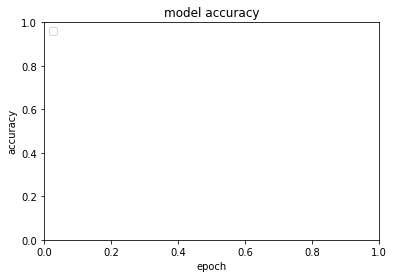

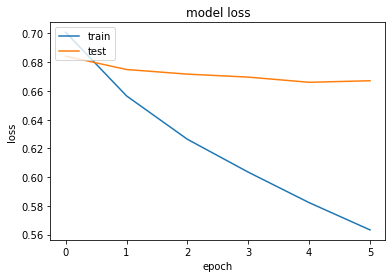

In [ ]:
#Let's try to plot the loss and accuracy differences 
#for training and test sets. Execute the following script:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### CNN

Convolutional neural network is a type of network that is primarily used for 2D data classification, such as images. A convolutional network tries to find specific features in an image in the first layer. In the next layers, the initially detected features are joined together to form bigger features. In this way, the whole image is detected.

Convolutional neural networks have been found to work well with text data as well. Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data. To learn more about convolutional neural networks, please refer to this article.

Let's create a simple convolutional neural network with 1 convolutional layer and 1 pooling layer. Remember, the code up to the creation of the embedding layer will remain same, execute the following piece of code after you create the embedding layer:

In [ ]:
from keras.layers import Conv1D

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In the above script we create a sequential model, followed by an embedding layer. This step is similar to what we had done earlier. Next, we create a one-dimensional convolutional layer with 128 features, or kernels. The kernel size is 5 and the activation function used is sigmoid. Next, we add a global max pooling layer to reduce feature size. Finally we add a dense layer with sigmoid activation. The compilation process is the same as it was in the previous section.



In [ ]:
# Let's now see the summary of our model:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          369600    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 433,857
Trainable params: 64,257
Non-trainable params: 369,600
_________________________________________________________________
None


You can see that in the above case we don't need to flatten our embedding layer. You can also notice that feature size is now reduced using the pooling layer.

Let's now train our model and evaluate it on the training set. The process to train and test our model remains the same. To do so, we can use the fit and evaluate methods, respectively.

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

# To check the test accuracy and loss we run the following code

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/6
7/7 [==============================] - 1s 106ms/step - loss: 0.7098 - acc: 0.5223 - val_loss: 0.6593 - val_acc: 0.6135
Epoch 2/6
7/7 [==============================] - 1s 72ms/step - loss: 0.5768 - acc: 0.7286 - val_loss: 0.6526 - val_acc: 0.6232
Epoch 3/6
7/7 [==============================] - 0s 71ms/step - loss: 0.4875 - acc: 0.8481 - val_loss: 0.6410 - val_acc: 0.6425
Epoch 4/6
7/7 [==============================] - 0s 71ms/step - loss: 0.4403 - acc: 0.9019 - val_loss: 0.6411 - val_acc: 0.6232
Epoch 5/6
7/7 [==============================] - 1s 74ms/step - loss: 0.3938 - acc: 0.9075 - val_loss: 0.6451 - val_acc: 0.6232
Epoch 6/6
9/9 [==============================] - 0s 8ms/step - loss: 0.6466 - acc: 0.6409
Test Score: 0.6466220617294312
Test Accuracy: 0.6409266591072083


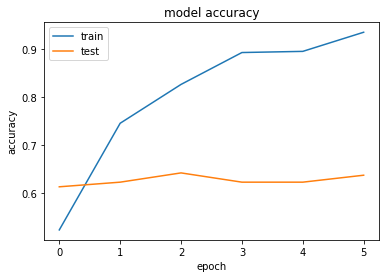

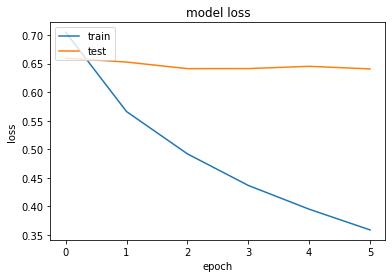

In [ ]:
#Let's plot the loss and accuracy difference between the training and test set.
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### RNN(LSTM)

Recurrent neural network is a type of neural networks that is proven to work well with sequence data. Since text is actually a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. In this section, we will use an LSTM (Long Short Term Memory network) which is a variant of RNN, to solve sentiment classification problem.

In [ ]:
# we start by initializing a sequential model followed by the creation of the embedding layer.
# Next, we create an LSTM layer with 128 neurons (You can play around with number of neurons). 
#The rest of the code is same as it was for the CNN.
from keras.layers import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
#Let's plot the summary of our model.
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          369600    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 486,977
Trainable params: 117,377
Non-trainable params: 369,600
_________________________________________________________________
None


In [ ]:
#train the model on the training set 
#and evaluate its performance on the test set.
history = model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

# To check the test accuracy and loss we run the following code

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/8
7/7 [==============================] - 4s 367ms/step - loss: 0.6912 - acc: 0.5682 - val_loss: 0.6767 - val_acc: 0.6135
Epoch 2/8
7/7 [==============================] - 2s 278ms/step - loss: 0.6824 - acc: 0.5709 - val_loss: 0.6677 - val_acc: 0.6135
Epoch 3/8
7/7 [==============================] - 2s 280ms/step - loss: 0.6767 - acc: 0.5911 - val_loss: 0.6706 - val_acc: 0.6135
Epoch 4/8
7/7 [==============================] - 2s 283ms/step - loss: 0.6758 - acc: 0.5956 - val_loss: 0.6695 - val_acc: 0.6135
Epoch 5/8
7/7 [==============================] - 2s 277ms/step - loss: 0.6829 - acc: 0.5716 - val_loss: 0.6673 - val_acc: 0.6135
Epoch 6/8
7/7 [==============================] - 2s 277ms/step - loss: 0.6766 - acc: 0.5927 - val_loss: 0.6678 - val_acc: 0.6135
Epoch 7/8
7/7 [==============================] - 2s 272ms/step - loss: 0.6719 - acc: 0.6024 - val_loss: 0.6720 - val_acc: 0.6135
Epoch 8/8
9/9 [==============================] - 0s 22ms/step - loss: 0.6882 - acc: 0.5521
Test S

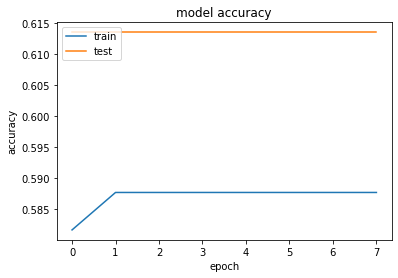

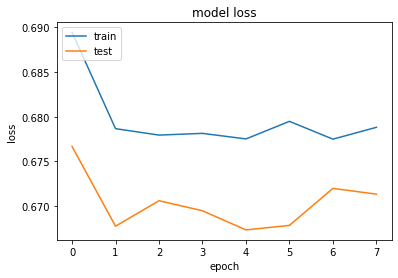

In [ ]:
#Let's plot the loss and accuracy differences between training and test sets.

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Topic Modeling- LDA (Latent Dirichlet Allocation)


### Preprocessing 

In [29]:
import pandas as pd
dat= pd.read_csv('/content/final_hatespeech2.csv')
#final.drop('Unnamed: 0', inplace= True)
dat.head()

Unnamed: 0  ...                                                                       tweet
0           0  ...  point correction kambas practise witchcraft pamba practise african science
1           1  ...                                                           luhyas group food
2           2  ...                                                 beat bush waluhya character
3           3  ...                                                act generosity common kambas
4           4  ...                                                    luos luhyas 80 plus year

[5 rows x 3 columns]

In [30]:
dat.isnull().sum()
dat.dropna(inplace=True)
dat.isnull().sum()

Unnamed: 0     0
hate_speech    0
tweet          0
dtype: int64

In [31]:
dat.columns

Index(['Unnamed: 0', 'hate_speech', 'tweet'], dtype='object')

In [32]:
# let us select tweets marked as hate speech
hate = dat.loc[dat.hate_speech == 1]
hate.shape
tweet = hate.drop(['Unnamed: 0',	'hate_speech'], axis = 1)
tweet.head()

tweet
0                                                   point correction kambas practise witchcraft pamba practise african science
6                                      yes -PRON- lius luhyas like 2 3 week bury -PRON- change money -PRON- share person alive
8   -PRON- baer trade -PRON- amidst -PRON- long distance chader -PRON- ghana gun vaine bring -PRON-   panic -PRON- right truck
9                                                                                               -PRON- upset waeh -PRON- scary
11                                                                 islamic luhyas survive fast period ooh poor mohammad wafula

In [ ]:
!pip install pyLDAvis

In [34]:
import pyLDAvis
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
pyLDAvis.enable_notebook()

In [35]:
# Build the bigram and trigrams
data = tweet.tweet
bigram = gensim.models.Phrases(data, min_count=20, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [36]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
# define a function for preprocessing:
# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# get stopwords from nltk library
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    
    # bi-gram and tri-gram implementation
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

In [38]:
data_ready = process_words(data)

In [39]:
# The model requires a dictionary and a corpus to process. 
# Dictionary contains all the words and numerical identifiers one for each unique word. 
# On the other hand, corpus is a list of lists containing tuples for each word id and its frequency.
# create dictionary and get the length of vocabulary:
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 1481


In [40]:
# create corpus:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [42]:
#Now, I create a dictionary and then convert it to a dataframe 
#that shows each word in the corpus and its frequency:
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

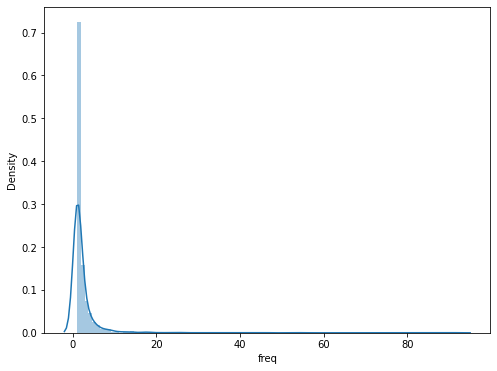

In [43]:
# Let’s make a histogram that shows word frequencies to better understand the corpus:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [44]:
#Let’s see these top 10 high-frequency words in descending order.
dict_df.sort_values('freq', ascending=False).head(10)

freq
tribal    92
pron      55
vote      46
know      43
people    40
luhyas    32
bbi       30
think     27
time      25
come      25

In [45]:
# Now we should set a threshold to filter out high-frequency words. It’s more or less a trial and error step. 
#For my corpus, I set it to 20 and will filter out those words that have frequency over 20. 
#Let’s store those words in a list:
extension = dict_df[dict_df.freq>20].index.tolist()

# we can add those words to stop words list and rerun the process_words function, 
# since these words have an effect on forming bi-grams and tri-grams.
# add high frequency words to stop words list
stop_words.extend(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 1356


In [46]:
# Filter out words that occur less than 10 documents, or more than
# 50% of the documents.
# id2word.filter_extremes(no_below=1, no_above=0.5)
# print('Total Vocabulary Size:', len(id2word))

In [47]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### Model

In [ ]:
# Let’s start with installing Mallet package
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [49]:
# We should define path to the mallet binary to pass in LdaMallet wrapper:
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [50]:
# We should specify the number of topics in advance. 
#Although there isn’t an exact method to decide the number of topics, 
#in the last section we will compare models that have different number of topics based on their coherence scores.
# For now, build the model for 3 topics (this may take some time based on your corpus):
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=3, id2word=id2word)

In [51]:
# Let’s display the 10 topics formed by the model
# we will print (use pretty print for a better view) 
# 3 terms and their relative weights next to it in descending order.
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('thief', 0.019157088122605363),
   ('leader', 0.017879948914431672),
   ('election', 0.016602809706257982),
   ('long', 0.011494252873563218),
   ('fact', 0.010217113665389528),
   ('work', 0.010217113665389528),
   ('position', 0.010217113665389528),
   ('family', 0.010217113665389528),
   ('mess', 0.008939974457215836),
   ('business', 0.008939974457215836)]),
 (1,
  [('country', 0.022641509433962263),
   ('good', 0.02012578616352201),
   ('stop', 0.01761006289308176),
   ('pay', 0.016352201257861635),
   ('big', 0.01509433962264151),
   ('power', 0.012578616352201259),
   ('political', 0.012578616352201259),
   ('high', 0.011320754716981131),
   ('food', 0.011320754716981131),
   ('jayden', 0.00880503144654088)]),
 (2,
  [('raila', 0.019559902200488997),
   ('hate', 0.017114914425427872),
   ('thing', 0.017114914425427872),
   ('tribe', 0.014669926650366748),
   ('man', 0.014669926650366748),
   ('person', 0.009779951100244499),
   ('eat', 0.009779951100244499),
   ('suffer

Note that, the model returns only clustered terms not the labels for those clusters. We are required to label topics.

In [52]:
# We can calculate the coherence score of the model to compare it with others.
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.7339199081786062


In [53]:
# We can get the topic modeling results (distribution of topics for each document) 
#if we pass in the corpus to the model. You can also pass in a specific document; 
#for example, ldamallet[corpus[0]] returns topic distributions for the first document. 
#For the whole documents, we write:
tm_results = ldamallet[corpus]

In [54]:
# We can get the most dominant topic of each document as below:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [55]:
#To get most probable words for the given topicid, 
#we can use show_topic() method. It returns sequence of probable words,
# as a list of (word, word_probability) for specific topic. 
# You can get top 20 significant terms and their probabilities for each topic as below:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] 
          for n in range(0, ldamallet.num_topics)]

In [56]:
# We can create a dataframe for term-topic matrix:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)], 
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

Topic 1  Topic 2 Topic 3
Term1     thief  country   raila
Term2    leader     good    hate
Term3  election     stop   thing
Term4      long      pay   tribe
Term5      fact      big     man

In [57]:
# Another option is to display all the terms for a topic in a single row as below:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

Terms per Topic
Topic1  thief, leader, election, long, fact, position, work, family, guy, leave, change, true, business, mess, week, luos, fail, point, play, life     
Topic2  country, good, stop, pay, big, power, political, food, high, send, jayden, steal, problem, talk, year, rope, government, run, continue, corrupt
Topic3  raila, hate, thing, tribe, man, eat, suffer, person, politic, wise, loan, bring, chief, kenyan, job, history, wait, gun, plan, dead

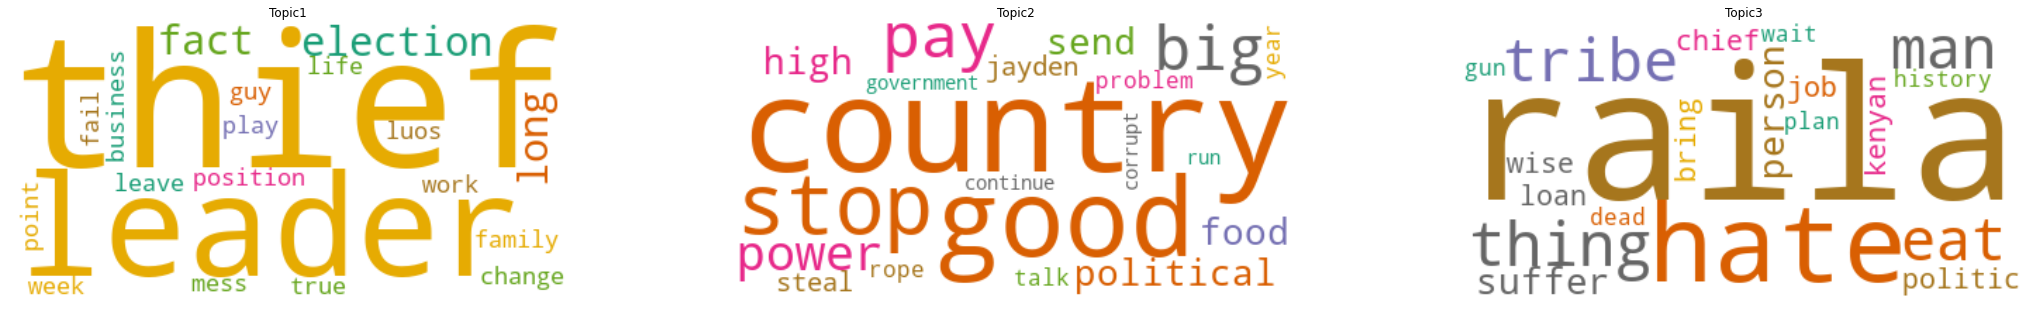

In [58]:
# Visualize the terms as wordclouds
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [50, 30]

# Create subplots for each topic
for i in range(3):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [59]:
# Visualization with pyLDAvis
# To use this library, you need to convert LdaMallet model to a gensim model
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [60]:
# After defining the function we call it passing in our “ldamallet” model:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [61]:
# Then, we need to transform the topic model distributions and related corpus data 
#into the data structures needed for the visualization, as below:
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

In [62]:
# We can create a dataframe that shows dominant topic for each document and its percentage in the document.
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
corpus_topic_df['Tweet'] = tweet.tweet
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

Tweet  ...                                                                                                                                      Topic Terms
0   point correction kambas practise witchcraft pamba practise african science                                                  ...  thief, leader, election, long, fact, position, work, family, guy, leave, change, true, business, mess, week, luos, fail, point, play, life     
6   yes -PRON- lius luhyas like 2 3 week bury -PRON- change money -PRON- share person alive                                     ...  thief, leader, election, long, fact, position, work, family, guy, leave, change, true, business, mess, week, luos, fail, point, play, life     
8   -PRON- baer trade -PRON- amidst -PRON- long distance chader -PRON- ghana gun vaine bring -PRON-   panic -PRON- right truck  ...  raila, hate, thing, tribe, man, eat, suffer, person, politic, wise, loan, bring, chief, kenyan, job, history, wait, gun, plan, dead            
9   -PRON- upset waeh -PRON- scary                                                                                              ...  thief, leader, election, long, fact, position, work, family, guy, leave, change, true, business, mess, week, luos, fail, point, play, life     
11  islamic luhyas survive fast period ooh poor mohammad wafula                                                                 ...  country, good, stop, pay, big, power, political, food, high, send, jayden, steal, problem, talk, year, rope, government, run, continue, corrupt

[5 rows x 4 columns]

In [63]:
#We can use pandas groupby function on “Dominant Topic” column and get the document 
#counts for each topic and its percentage in the corpus with chaining agg function.
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

Dominant Topic  Doc_Count  Total_Docs_Perc
0  1               239        44.51          
1  2               160        29.80          
2  3               138        25.70

In [64]:
# We can also get which document makes the highest contribution to each topic:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

Tweet  ...                                                                                                                                      Topic Terms
0  s like mass haemorrhage duo come   -PRON- perfidied uks exit   loyal stick dp coalition -PRON-   -PRON- replace immediately high rating player  ...  thief, leader, election, long, fact, position, work, family, guy, leave, change, true, business, mess, week, luos, fail, point, play, life     
1  suppo dr mukhisa kituyi -PRON- s good lead economic recovery come close -PRON- rooted tribalism especially kale luos good tribe emulate luhyas  ...  country, good, stop, pay, big, power, political, food, high, send, jayden, steal, problem, talk, year, rope, government, run, continue, corrupt
2  thing hate black car -PRON- shameless neighbor mannerless fucklet scratch -PRON- car -PRON- visible like jaydens greed                          ...  raila, hate, thing, tribe, man, eat, suffer, person, politic, wise, loan, bring, chief, kenyan, job, history, wait, gun, plan, dead            

[3 rows x 4 columns]

# Topic Modeling- LSA (Latent Semantic Analysis)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)
dat= pd.read_csv('/content/final_hatespeech2.csv')
#final.drop('Unnamed: 0', inplace= True)
dat.head()

Unnamed: 0  ...                                                                       tweet
0           0  ...  point correction kambas practise witchcraft pamba practise african science
1           1  ...                                                           luhyas group food
2           2  ...                                                 beat bush waluhya character
3           3  ...                                                act generosity common kambas
4           4  ...                                                    luos luhyas 80 plus year

[5 rows x 3 columns]

In [2]:
dat.isnull().sum()
dat.dropna(inplace=True)
dat.isnull().sum()

Unnamed: 0     0
hate_speech    0
tweet          0
dtype: int64

In [3]:
# let us select tweets marked as hate speech
hate = dat.loc[dat.hate_speech == 1]
hate.shape
tweet = hate.drop(['Unnamed: 0',	'hate_speech'], axis = 1)
tweet.head()

tweet
0                                                   point correction kambas practise witchcraft pamba practise african science
6                                      yes -PRON- lius luhyas like 2 3 week bury -PRON- change money -PRON- share person alive
8   -PRON- baer trade -PRON- amidst -PRON- long distance chader -PRON- ghana gun vaine bring -PRON-   panic -PRON- right truck
9                                                                                               -PRON- upset waeh -PRON- scary
11                                                                 islamic luhyas survive fast period ooh poor mohammad wafula

In [4]:
#This is the first step towards topic modeling.
# We will use sklearn’s TfidfVectorizer to create a document-term matrix with 1,000 terms.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(tweet['tweet'])

X.shape # check shape of the document-term matrix

(537, 1000)

In [5]:
#The next step is to represent each and every term and document as a vector. 
#We will use the document-term matrix and decompose it into multiple matrices.
# We will use sklearn’s TruncatedSVD to perform the task of matrix decomposition.

# The number of topics can be specified by using the n_components parameter.

from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=3, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)
len(svd_model.components_)

3

In [6]:
#The components of svd_model are our topics, and we can access them using svd_model.components_.
# Finally, let’s print a few most important words in each of the 3 topics and see how our model has done.

terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
tribal
 
jayden
 
kenya
 
vote
 
bbi
 
like
 
know
 
Topic 1: 
jayden
 
look
 
kenya
 
control
 
open
 
gun
 
deal
 
Topic 2: 
tribal
 
jayden
 
kingpin
 
fool
 
corrup
 
appoint
 
corrupt
 


In [ ]:
!pip uninstall umap
!pip install umap-learn

In [ ]:
!pip install 'umap-learn==0.3.10'

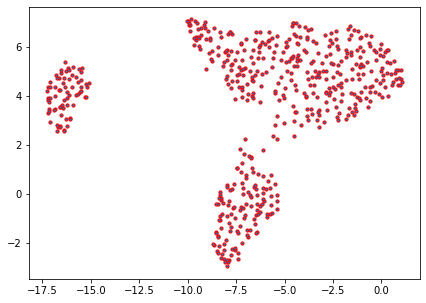

In [66]:
#Topics Visualization
#To find out how distinct our topics are, we should visualize them. 
#Of course, we cannot visualize more than 3 dimensions, 
#but there are techniques like PCA and t-SNE which can help us visualize high dimensional data into lower dimensions.
# Here we will use a relatively new technique called UMAP (Uniform Manifold Approximation and Projection).

import umap.umap_ as umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()

# Unsupervised Learning Using Vader

VADER stands for Valence Aware Dictionary and sEntiment Reasoner. Vader performs well for the analysis of sentiments expressed in social media. These sentiments must be present in the form of comments, tweets, retweets, or post descriptions, and it works well on texts from other domains also.VADER is a lexicon and rule-based analysis tool.

There are different types of sentiment analysis techniques available for extracting meaning insights from the text data, but the VADER sentiment performs well mainly on social media data. Later on, we design our VADER sentiment model, which extracts features from twitter data, formulate the sentiment score, and classifies them in positive, negative, neutral classes.

In [ ]:
my_data = pd.read_csv('/content/clean_hatespeech2.csv')
df = my_data.drop(columns = ['Unnamed: 0', 'hate_speech', 'location', 'friends_count',
       'followers_count', 'statuses_count', 'tweet_date', 'retweet_count',
       'likes'])
df.head()

tweet
0  @Keiyot_ @JohnRoyMwaniki @KereYvonne @NelsonHa...
1                  @MissKwegah1 Luhyas group of food
2  @smileycherry2 Don't beat around the bush, wal...
3  @Cockey_ninja @AizoOzill Act of generosity whi...
4  @ArapTilingi Luos and Luhyas have been doing t...

In [ ]:
#cleaning the tweets
import numpy as np
import re

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

df['tweet'] = clean_tweets(df['tweet'])
df['tweet'].head()

0        Point of correction: Kambas don't practise...
1                                 Luhyas group of food
2     Don't beat around the bush, waluhya lazima mu...
3      Act of generosity which is common among kambas😊
4     Luos and Luhyas have been doing this for the ...
Name: tweet, dtype: object

In [ ]:
# install vader if not already available
!pip install vaderSentiment

     |████████████████████████████████| 133kB 5.7MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
#Let us analyze some statements using VADER now. We are using the polarity_scores() 
#method to calculate the sentiment score for given sentences.
analyser.polarity_scores("I am getting bored in the quarantine.")

{'compound': -0.2732, 'neg': 0.259, 'neu': 0.741, 'pos': 0.0}

In [ ]:
# Finding scores for tweets
scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(df['tweet'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = analyser.polarity_scores(df['tweet'][i])["compound"]
    pos = analyser.polarity_scores(df['tweet'][i])["pos"]
    neu = analyser.polarity_scores(df['tweet'][i])["neu"]
    neg = analyser.polarity_scores(df['tweet'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })
#Converting the scores dictionary containing the scores into the data frame, 
#then join the sentiments_score data frame with the df data frame.
sentiments_score = pd.DataFrame.from_dict(scores)
df = df.join(sentiments_score)
df.head()

tweet  ...  Neutral
0      Point of correction: Kambas don't practise...  ...    1.000
1                               Luhyas group of food  ...    1.000
2   Don't beat around the bush, waluhya lazima mu...  ...    0.710
3    Act of generosity which is common among kambas😊  ...    0.518
4   Luos and Luhyas have been doing this for the ...  ...    1.000

[5 rows x 5 columns]

In [ ]:
df.to_csv('vader_sentiment.csv')

In [ ]:
# Collecting Hashtags
HT_positive = []
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags
# extracting hashtags from positive tweetsHT_positive = hashtag_extract(df_tws['text'][df_tws['sent'] == 1])
# extracting hashtags from  tweets
HT_positive = hashtag_extract(df['tweet'][df['Compound'] > 0.5])
# unnesting list
HT_positive = sum(HT_positive,[])
HT_positive

['TeamBBI',
 'Uhuru',
 'AcknowledgeMe',
 'YouDeserveTheTruth',
 'RingtoneApokoBackslides',
 'Ndii',
 'IMFStopLoaningKenya',
 'IMFStopLoaningKenya',
 'ReleaseKiama',
 'DayBreak',
 'NamuExposesRuto',
 'Newsnight',
 'Newsnight',
 'Newsnight',
 'Malizauende',
 'Daybreak',
 'DayBreak']

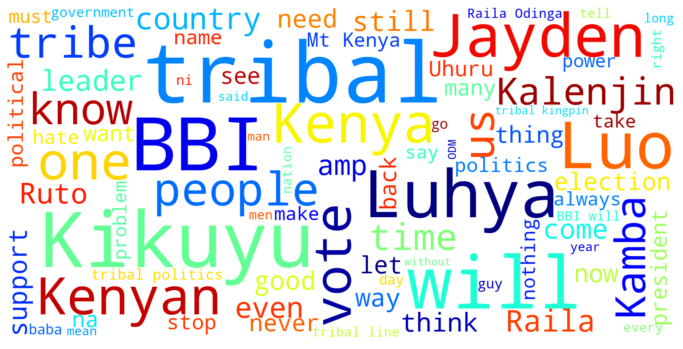

In [ ]:
#Plotting Wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(df['tweet'])